In [1]:
import torch
from networks.resnet_encoder import resnet50

ModuleNotFoundError: No module named 'networks'

In [ ]:
model = resnet50()

In [ ]:
x = model(torch.rand(1,3,640,480))
print(x['x1'].shape)
print(x['x2'].shape)
print(x['x3'].shape)
print(x['x4'].shape)
print(x['x5'].shape)

torch.Size([1, 64, 320, 240])
torch.Size([1, 256, 160, 120])
torch.Size([1, 512, 80, 60])
torch.Size([1, 1024, 40, 30])
torch.Size([1, 2048, 20, 15])


In [ ]:
import imp
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import OrderedDict
import numpy as np

def upsample(x):
    """Upsample input tensor by a factor of 2
    """
    return F.interpolate(x, scale_factor=2, mode="nearest")

class ConvBlock(nn.Module):
    """Layer to perform a convolution followed by ELU
    """
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()

        self.conv = Conv3x3(in_channels, out_channels)
        self.nonlin = nn.ELU(inplace=True)

    def forward(self, x):
        out = self.conv(x)
        out = self.nonlin(out)
        return out


class Conv3x3(nn.Module):
    """Layer to pad and convolve input
    """
    def __init__(self, in_channels, out_channels, use_refl=True):
        super(Conv3x3, self).__init__()

        if use_refl:
            self.pad = nn.ReflectionPad2d(1)
        else:
            self.pad = nn.ZeroPad2d(1)
        self.conv = nn.Conv2d(int(in_channels), int(out_channels), 3)

    def forward(self, x):
        out = self.pad(x)
        out = self.conv(out)
        return out
        
class DepthDecoder(nn.Module):
    def __init__(self, num_ch_enc, scales=range(4), num_output_channels=1, use_skips=True):
        super(DepthDecoder, self).__init__()

        self.num_output_channels = num_output_channels
        self.use_skips = use_skips
        self.upsample_mode = 'nearest'
        self.scales = scales

        self.num_ch_enc = num_ch_enc
        self.num_ch_dec = np.array([16, 32, 64, 128, 256])

        # decoder
        self.convs = OrderedDict()
        for i in range(4, -1, -1):
            # upconv_0
            num_ch_in = self.num_ch_enc[-1] if i == 4 else self.num_ch_dec[i + 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 0)] = ConvBlock(num_ch_in, num_ch_out)

            # upconv_1
            num_ch_in = self.num_ch_dec[i]
            if self.use_skips and i > 0:
                num_ch_in += self.num_ch_enc[i - 1]
            num_ch_out = self.num_ch_dec[i]
            self.convs[("upconv", i, 1)] = ConvBlock(num_ch_in, num_ch_out)

        for s in self.scales:
            self.convs[("dispconv", s)] = Conv3x3(self.num_ch_dec[s], self.num_output_channels)

        self.decoder = nn.ModuleList(list(self.convs.values()))
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_features):
        self.outputs = {}
        input_features = [x['x1'],x['x2'],x['x3'],x['x4'],x['x5']]
        # decoder
        x = input_features[-1]
        for i in range(4, -1, -1):
            x = self.convs[("upconv", i, 0)](x)
            x = [upsample(x)]
            if self.use_skips and i > 0:
                x += [input_features[i - 1]]
            x = torch.cat(x, 1)
            x = self.convs[("upconv", i, 1)](x)
            if i in self.scales:
                self.outputs[("disp", i)] = self.sigmoid(self.convs[("dispconv", i)](x))

        return self.outputs

        

        

        


c:\Users\neetm\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  """Entry point for launching an IPython kernel.


In [ ]:
from networks.depth_network import DepthNetwork
model = DepthNetwork()

In [ ]:
x = model(torch.rand(1,3,640,480))

In [ ]:
try:
    from PIL import Image
except ImportError:
    import Image
i1 = r"E:\Deep Learning Projects\datasets\kitti_raw\2011_09_26\2011_09_26_drive_0002_sync\image_02\data\0000000059.png"
i2 = r"E:\Deep Learning Projects\datasets\kitti_raw\2011_09_26\2011_09_26_drive_0002_sync\image_03\data\0000000059.png"
background = Image.open(i1)
overlay = Image.open(i2)

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.5)
new_img.save("new.png","PNG")

In [3]:
import os
from os.path import join as osp
import pandas as pd

def num_parser(num):
    num1 = str(num)
    num2 = '0'*(10-len(num1))
    return num2+num1

root = r"E:\Deep Learning Projects\datasets\kitti_raw"
runs = os.listdir(root)
with open(r'E:\Deep Learning Projects\monodepth_from_scratch\splits\eigen_full\val_files.txt', 'r') as f:
    list1 = f.readlines()
    img_dict = {}
    for i in list1:
        path, num, pos = i.split()
        path.replace('/','\\')
        img_path = osp(path, f"image_02\\data\\{num_parser(num)}.png")
        if path not in img_dict:
            img_dict[path] = []

        img_dict[path].append(int(num))

sample_list = []
for key,value in img_dict.items():
    
    img_dict[key] = list(set(img_dict[key]))
    img_dict[key].sort()

    for i in range(len(img_dict[key])-1):
        sample = [osp(root,key,f"image_02\\data\\{num_parser(img_dict[key][i])}.png"), osp(root,key,f"image_02\\data\\{num_parser(img_dict[key][i+1])}.png")]
        sample_list.append(sample)

train = pd.DataFrame(columns=['target', 'source'], data=sample_list)
train.to_csv('val.csv')

        

In [ ]:
train.iloc[0]

target    E:\Deep Learning Projects\datasets\kitti_raw\2...
source    E:\Deep Learning Projects\datasets\kitti_raw\2...
Name: 0, dtype: object

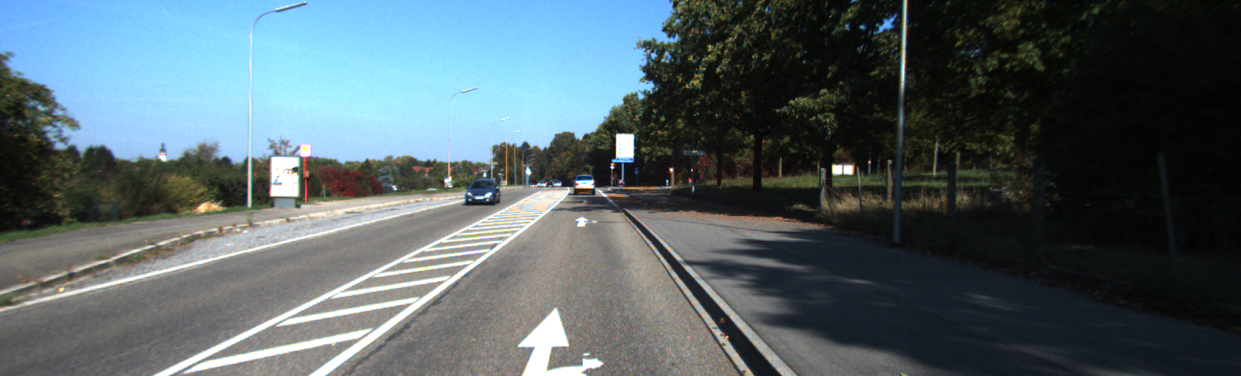

In [1]:
from kitti import KittiStereo

ds = KittiStereo('train.csv')
ds[0]['target']

In [2]:
try:
    from PIL import Image
except ImportError:
    import Image

background = ds[0]['target']
overlay = ds[0]['source']

background = background.convert("RGBA")
overlay = overlay.convert("RGBA")

new_img = Image.blend(background, overlay, 0.5)
new_img.save("new.png","PNG")

In [2]:
a = 'net'
a[-1]='a'

TypeError: 'str' object does not support item assignment